In [ ]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image
from keras.applications import mobilenet_v2
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import seaborn as sns

In [24]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# Constants
DATA_SRC = 'garbage_classification/'
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10
MODEL_PATH = "./garbage_classification_model.h5"

In [26]:
filepaths = []
labels = []

for label in os.listdir(DATA_SRC):
    path = os.path.join(DATA_SRC, label)
    if not os.path.isdir(path) or label.startswith('.'):
        continue
    for file_name in os.listdir(path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(path, file_name))
            labels.append(label)
            
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [27]:
print(f"Number of images found: {len(df)}")
print(f"Class distribution: {df['label'].value_counts()}")
df.sample(frac=1)

Number of images found: 15515
Class distribution: label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


,filepath,label
7073,garbage_classification/clothes\clothes428.jpg,clothes
2835,garbage_classification/cardboard\cardboard368.jpg,cardboard
904,garbage_classification/battery\battery913.jpg,battery
3369,garbage_classification/cardboard\cardboard849.jpg,cardboard
8307,garbage_classification/clothes\clothes598.jpg,clothes
...,...,...
2751,garbage_classification/cardboard\cardboard292.jpg,cardboard
10040,garbage_classification/metal\metal692.jpg,metal
1759,garbage_classification/biological\biological83...,biological
52,garbage_classification/battery\battery146.jpg,battery


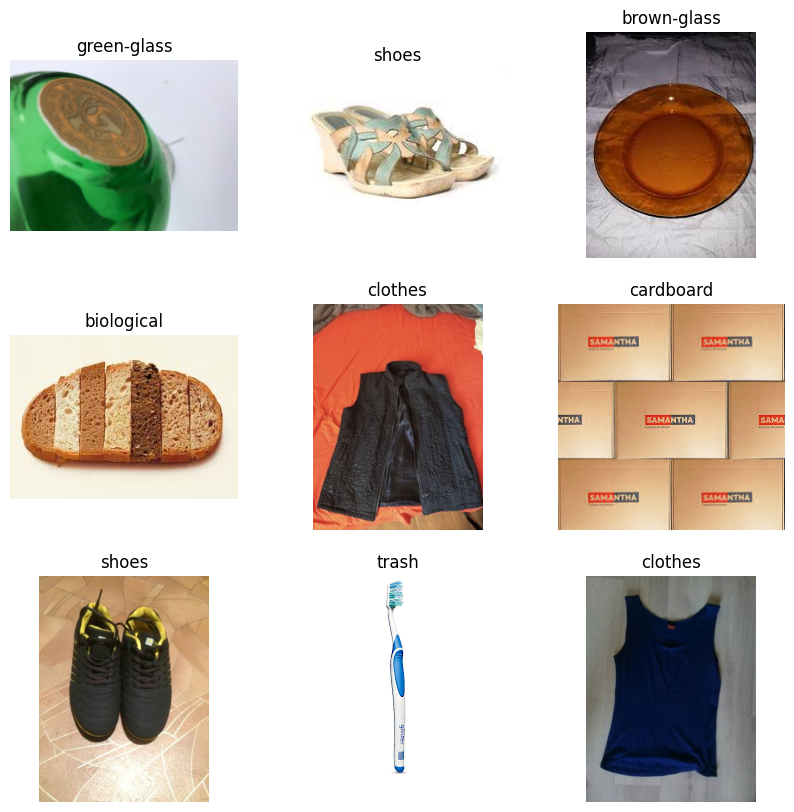

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(df))
    img_path = df.iloc[idx]['filepath']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(df.iloc[idx]['label'])
    ax.axis('off')

# Model training

In [ ]:
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
model.add(Lambda(lambda x: mobilenet_v2.preprocess_input(x)))
model.add(mobile_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(df['label'].unique()), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)

model.summary()

In [30]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=123,stratify=df['label'])
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=123,stratify=validate_df['label'])

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_total = train_df.shape[0]
validate_total = validate_df.shape[0]

In [ ]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=3, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

# Plateau will help to optimize the training  passively as the epochs go by.
plateau = ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, plateau]

In [32]:

train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = train_data_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
)

Found 12412 validated image filenames belonging to 12 classes.


In [33]:
validation_data_gen = ImageDataGenerator(
)
validation_generator = validation_data_gen.flow_from_dataframe(
    validate_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2172 validated image filenames belonging to 12 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//BATCH_SIZE,
    callbacks=callbacks
)

model.save(MODEL_PATH)

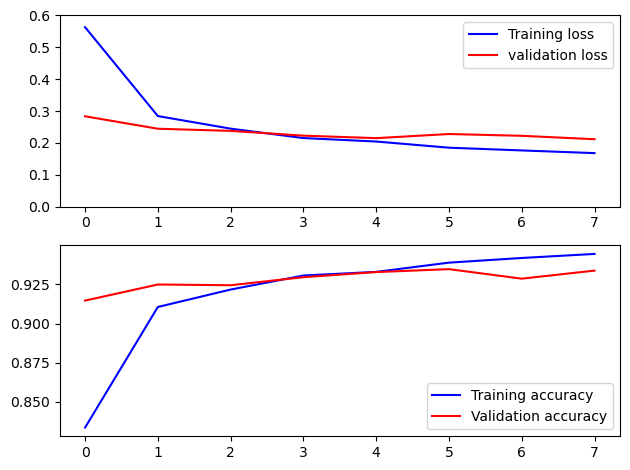

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 931 validated image filenames belonging to 12 classes.


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

/home/yousuf/miniconda3/envs/garbageclassifier/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
              precision    recall  f1-score   support

     battery       0.90      0.96      0.93        57
  biological       0.98      0.98      0.98        59
 brown-glass       0.87      0.92      0.89        37
   cardboard       1.00      0.85      0.92        53
     clothes       0.98      0.98      0.98       320
 green-glass       0.86      0.97      0.91        38
       metal       0.75      0.85      0.80        46
       paper       0.87      0.84      0.85        63
     plastic       0.82      0.63      0.72        52
       shoes       0.90      0.95      0.93       118
       trash       0.97      0.83      0.90        42
 white-glass       0.80      0.85      0.82        46

    accuracy                           0.92       931
   macro avg       0.89      0.89      0.89       931
weighted avg       0.92      0.92      0.92       931



<Axes: >

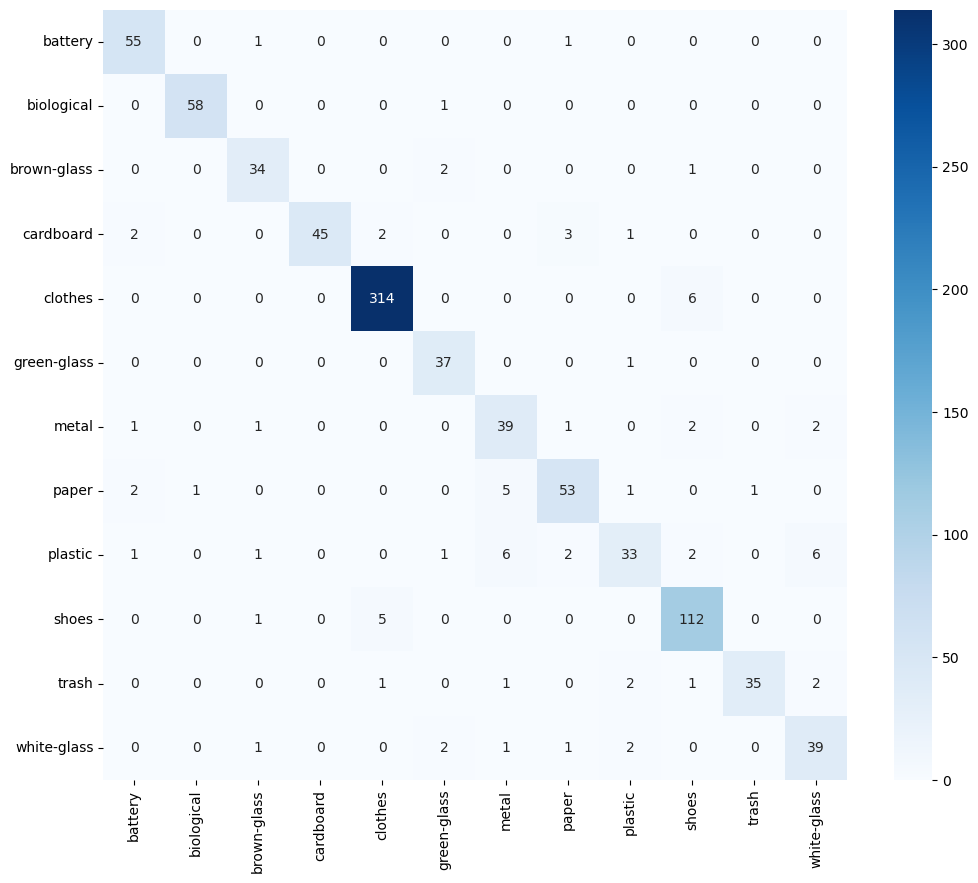

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)

In [ ]:
try:
    new_model = load_model(MODEL_PATH)
    print(f"Model {MODEL_PATH} has been loaded successfully.")
except Exception as e:
    print("ERROR: Model has not been loaded.", e)
    exit(1)

ERROR: Model has not been loaded. No model config found in the file at ./garbage_classification.weights.h5.


In [ ]:
CAM_INDEX = 0
video_stream = cv2.VideoCapture(CAM_INDEX)
if not video_stream.isOpened():
    print("ERROR: Could not open camera.")
    exit(1)
print("Press 'ESC' to quit")

In [ ]:
while True:
    # Capture frame-by-frame
    ret, frame = video_stream.read()

    if not ret:
        print("ERROR: Can't receive frame.")
        break
    
    stream_size = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    stream_rgb = cv2.cvtColor(stream_size, cv2.COLOR_BGR2RGB)